# Калибровка вероятности дефолта

Для принятия решения важно не только учметь разделять между собой "хороших" клиентов от "плохих", но и достаточно точно прогнозировать вероятность начтупления дефолта. Когда качество разделения модели достаточно сильное, но попадание в реальные риски плохое, можно производить калибровку - несложное преобразование прогноза вероятности дефолта. Данная задача также часто возникает, когда появляется новый продукт или новый сегмент слабо представленный в обучающей выборке, и  возможность перестраивания модели отсутствует.

В данном ноутбуке мы рассмотрим несколько подходов к калибровки модели.

Загрузим сначала выборку с данными.

In [6]:
import pandas as pd
import numpy as np
%matplotlib inline

url_calibration = 'https://www.dropbox.com/s/a5tlpq8njxg5d33/calibration.csv?dl=1'
df = pd.read_csv(url_calibration)
df.head()

,pd,default_flg,category_feature
0,0.108868,0,E
1,0.146724,0,E
2,0.094514,0,E
3,0.092973,0,C
4,0.265591,1,E


In [2]:
df.shape

(30000, 3)

В данной выборке присутствует 30000 наблюдений, и три поля.

# Визуализация качества прогноза

Выборка разбивается на равные по количеству бакеты в зависимости от значения прогноза. В каждом бакете считается средний прогноз и частота наступления дефолта.

In [3]:
def plot_gain_chart(target, prob, num_buck=10):    
    data = pd.DataFrame({'target': target, 'predict': prob})
    buckets = pd.qcut(prob, q=num_buck)
    aggregated = data.groupby(buckets).agg({'target': 'mean', 'predict': 'mean'})
    aggregated = aggregated.sort_index(ascending=False).reset_index(drop=True)
    aggregated.plot(kind='bar', grid=True)

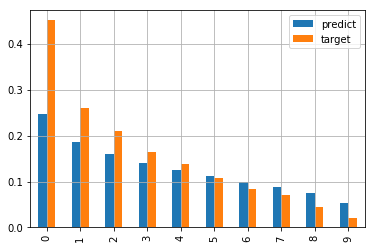

In [4]:
plot_gain_chart(df['default_flg'], df['pd'])

По данной диаграмме видно, что среди бакетов [0, 1, 2] реальная частота дефолтов оказывается выше, чем средний прогноз.  

К массиву `df['pd']` можно применять арифметические преобразования, которые применяются поэлементно.

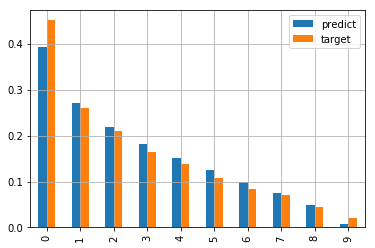

In [5]:
plot_gain_chart(df['default_flg'], 2 * df['pd'] - 0.1)

Так же можно применять и любые преобразования из из numpy, которые так же поэлементные. Например, `np.exp()` или `np.sin()`.

# Калибровка логистической регрессией

В логистической регрессии присутствует сигмоидное преобразование $\sigma(x) = \frac{1}{1+exp(-x)}$.  

**Задание. Напишите функцию логистического преобразования, которое является обратным к сигмоидному.**

In [1]:
import numpy as np
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def logit(x):    
    return np.log(x / (1 - x))

Создадим новый столбец `logit` в таблице

In [11]:
df['logit'] = logit(df['pd'])

**Задание. Нарисуйте теперь диаграмму рассеивания между `logit` и `pd`. Точки должны лечь на часть сигмоиды.**

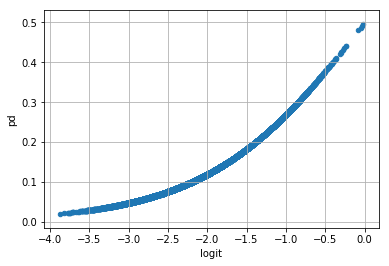

In [17]:
df.plot(x='logit', y='pd', kind='scatter', grid=True);

Произведем калибровку, обучив логистическую регрессию на одном признаке `df['logit']`.  
В scikit-learn алгоритм машинного обучения выглядят следующим образом:

In [18]:
from sklearn.linear_model import LogisticRegression

classifier = LogisticRegression()                                      # Определяем объект - классификатор
classifier.fit( df[['logit']], df['default_flg'] );                    # Производим обучение, вызвав метод fit

После обучения (запуска метода `.fit()`), у обекта `classifier` появляются атрибуты с коэффициентами

In [19]:
classifier.intercept_  # свободный член

array([ 1.99754727])

In [20]:
classifier.coef_       # коэффициенты перед признаками, в нашем случае всего одно число, так как признак один

array([[ 1.99923055]])

Посмотрим как теперь выглядит график gain chart.

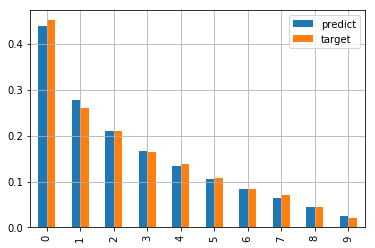

In [81]:
logistic_calibration = classifier.predict_proba(df[['logit']])[:, 1]

plot_gain_chart(df['default_flg'], logistic_calibration)

Столбики с прогнозом и с частотой дефолтов стали гораздо ближе.  
Помимо визуализации полезно так же считать формальные метрики.  
**Задание. Сравните между собой по разным метрикам точность двух прогнозов. Объясните результаты.**

In [82]:
from sklearn.metrics import roc_auc_score, log_loss, mean_squared_error

metrics = pd.DataFrame()  # можно создавать пустую таблицу, заполняя её позже

def add_metrics(metrics, target, predict, name):
    # для обращения к ячейкам есть метод .loc[название строки, название столбца]
    metrics.loc[name, 'MSE'     ] = mean_squared_error (target, predict)
    metrics.loc[name, 'AUC'     ] = roc_auc_score      (target, predict)
    metrics.loc[name, 'log_loss'] = log_loss           (target, predict)


add_metrics(metrics, df['default_flg'], df['pd'], 'pd')

add_metrics(metrics, df['default_flg'], logistic_calibration, 'logistic_calibration')

metrics

,MSE,AUC,log_loss
pd,0.121001,0.746103,0.392546
logistic_calibration,0.115498,0.746103,0.376995


**Задание. Посчитать метрики для тестовой выборки**

In [83]:
metrics_test = pd.DataFrame()

url_calibration_test = 'https://www.dropbox.com/s/s7bpm3tbzhqtvau/calibration_test.csv?dl=1'
df_test = pd.read_csv(url_calibration_test)

add_metrics(metrics_test, df_test['default_flg'], df_test['pd'], 'pd')
df_test['logit'] = logit(df_test['pd'])
logistic_calibration = classifier.predict_proba(df_test[['logit']])[:, 1]

add_metrics(metrics_test, df_test['default_flg'], logistic_calibration, 'logistic_calibration')
metrics_test

,MSE,AUC,log_loss
pd,0.120079,0.74249,0.390851
logistic_calibration,0.115102,0.74249,0.377082


# Калибровка линейной регрессией

Воспользуемся теперь линейной регрессией.  
Интерфейс обучения модели практически такой же.  

In [84]:
from sklearn.linear_model import LinearRegression

regressor = LinearRegression()
regressor.fit(df[['pd']], df['default_flg'])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

**Задание. Посчитайте метрики для прогноза `pd_linear`. Обясните результаты.**

In [85]:
# <вставить код>
predict = regressor.predict(df[['pd']])
add_metrics(metrics, df['default_flg'], predict, 'pd_linear')
metrics

,MSE,AUC,log_loss
pd,0.121001,0.746103,0.392546
logistic_calibration,0.115498,0.746103,0.376995
pd_linear,0.115812,0.746103,0.397966


In [86]:
# <вставить код>
predict = regressor.predict(df_test[['pd']])
add_metrics(metrics_test, df_test['default_flg'], predict, 'pd_linear')
metrics_test

,MSE,AUC,log_loss
pd,0.120079,0.74249,0.390851
logistic_calibration,0.115102,0.74249,0.377082
pd_linear,0.115397,0.74249,0.417158


# Калибровка [Isotonic regression](http://scikit-learn.org/stable/modules/isotonic.html)

<img src="http://scikit-learn.org/stable/_images/sphx_glr_plot_isotonic_regression_0011.png" width=500>

Логистическая и линейная регрессия находят зависимость между наборами признаков и целевой переменной, isotonic зависимость между всего одним признаком и целевой переменной. Но за-то поиск происходит в достаточно большом классе функций - все возможные монотонные преобразования.  

Из за наличия только одного признака в метод `.fit()` и `.predict()` нужно подавать одномерный массив с признаком, а не двумерную матрицу, как в прошлых моделях.

**Задание. Произведите калибровку isotonic regression и посчитайте метрики. Объясните результаты.**

In [87]:
from sklearn.isotonic import IsotonicRegression
isotonator = IsotonicRegression(out_of_bounds='clip')
isotonator.fit(df['pd'], df['default_flg'])
predict = isotonator.predict(df['pd'])
add_metrics(metrics, df['default_flg'], predict, 'pd_isotonator')
metrics

,MSE,AUC,log_loss
pd,0.121001,0.746103,0.392546
logistic_calibration,0.115498,0.746103,0.376995
pd_linear,0.115812,0.746103,0.397966
pd_isotonator,0.115050,0.747632,0.375388


In [88]:
# <вставить код> для тестовой выборки
predict = isotonator.predict(df_test['pd'])
add_metrics(metrics_test, df_test['default_flg'], predict, 'pd_isotonator')
metrics_test

,MSE,AUC,log_loss
pd,0.120079,0.742490,0.390851
logistic_calibration,0.115102,0.742490,0.377082
pd_linear,0.115397,0.742490,0.417158
pd_isotonator,0.114971,0.741982,0.382790


# Калибровка по отдельным группам

В выборке присутствует поле `category_feature`. Попробуем построить модель с использованием двух признаков: категории и `logit`.

In [89]:
import statsmodels.formula.api as smf

log_reg = smf.logit('default_flg ~ category_feature + logit', data=df).fit()
log_reg.summary2()

Optimization terminated successfully.
         Current function value: 0.374245
         Iterations 7


<class 'statsmodels.iolib.summary2.Summary'>
"""
                           Results: Logit
=====================================================================
Model:                Logit             Pseudo R-squared:  0.132     
Dependent Variable:   default_flg       AIC:               22466.7136
Date:                 2018-03-06 20:12  BIC:               22516.5673
No. Observations:     30000             Log-Likelihood:    -11227.   
Df Model:             5                 LL-Null:           -12940.   
Df Residuals:         29994             LLR p-value:       0.0000    
Converged:            1.0000            Scale:             1.0000    
No. Iterations:       7.0000                                         
---------------------------------------------------------------------
                       Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
---------------------------------------------------------------------
Intercept              2.0894   0.0798 26.1904 0.0000  1.9330  2.2458
category_feature[T.B] -0.5363   0.0636 -8.4270 0.0000 -0.6610 -0.4116
category_feature[T.C]  0.1578   0.0528  2.9892 0.0028  0.0543  0.2613
category_feature[T.D] -0.1388   0.0644 -2.1576 0.0310 -0.2650 -0.0127
category_feature[T.E] -0.0732   0.0534 -1.3710 0.1704 -0.1780  0.0315
logit                  2.0089   0.0390 51.5464 0.0000  1.9325  2.0852
=====================================================================

"""

In [90]:
add_metrics(metrics, df['default_flg'], log_reg.predict(df), 'category')
metrics

,MSE,AUC,log_loss
pd,0.121001,0.746103,0.392546
logistic_calibration,0.115498,0.746103,0.376995
pd_linear,0.115812,0.746103,0.397966
pd_isotonator,0.115050,0.747632,0.375388
category,0.114669,0.752288,0.374245


In [91]:
add_metrics(metrics_test, df_test['default_flg'], log_reg.predict(df_test), 'category')
metrics_test

,MSE,AUC,log_loss
pd,0.120079,0.742490,0.390851
logistic_calibration,0.115102,0.742490,0.377082
pd_linear,0.115397,0.742490,0.417158
pd_isotonator,0.114971,0.741982,0.382790
category,0.114312,0.749230,0.374144


Теперь возьмем только статистически значимые признаки

In [99]:
import statsmodels.api as sm
from patsy import dmatrices


y, X = dmatrices('default_flg ~ category_feature + logit', data=df, return_type='dataframe')
X = X.loc[:, log_reg.pvalues < 0.05]
log_reg_drop = sm.Logit(y, X).fit()

log_reg_drop.summary2()

Optimization terminated successfully.
         Current function value: 0.374276
         Iterations 7


<class 'statsmodels.iolib.summary2.Summary'>
"""
                           Results: Logit
=====================================================================
Model:                Logit             Pseudo R-squared:  0.132     
Dependent Variable:   default_flg       AIC:               22466.5864
Date:                 2018-03-06 20:22  BIC:               22508.1311
No. Observations:     30000             Log-Likelihood:    -11228.   
Df Model:             4                 LL-Null:           -12940.   
Df Residuals:         29995             LLR p-value:       0.0000    
Converged:            1.0000            Scale:             1.0000    
No. Iterations:       7.0000                                         
---------------------------------------------------------------------
                       Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
---------------------------------------------------------------------
Intercept              2.0419   0.0719 28.4033 0.0000  1.9010  2.1828
category_feature[T.B] -0.4891   0.0537 -9.1093 0.0000 -0.5944 -0.3839
category_feature[T.C]  0.2049   0.0403  5.0911 0.0000  0.1260  0.2838
category_feature[T.D] -0.0917   0.0545 -1.6811 0.0927 -0.1986  0.0152
logit                  2.0087   0.0390 51.5468 0.0000  1.9323  2.0851
=====================================================================

"""

In [79]:
add_metrics(metrics, df['default_flg'], log_reg_drop.predict(X), 'category_part')
metrics

,MSE,AUC,log_loss
pd,0.121001,0.746103,0.392546
logistic_calibration,0.115498,0.746103,0.376995
pd_linear,0.115812,0.746103,0.397966
pd_isotonator,0.115050,0.747632,0.375388
category,0.114669,0.752288,0.374245
category_part,0.114672,0.752201,0.374276


**Задание. посчитать качество на тестовой выборке**

In [100]:
# <вставить код>
y, X = dmatrices('default_flg ~ category_feature + logit', data=df_test, return_type='dataframe')
X = X.loc[:, log_reg.pvalues < 0.05]
add_metrics(metrics_test, df_test['default_flg'], log_reg_drop.predict(X), 'category_part')
metrics_test

,MSE,AUC,log_loss
pd,0.120079,0.742490,0.390851
logistic_calibration,0.115102,0.742490,0.377082
pd_linear,0.115397,0.742490,0.417158
pd_isotonator,0.114971,0.741982,0.382790
category,0.114312,0.749230,0.374144
category_part,0.114299,0.749378,0.374101


**Задание. Построить модель с формулой `default_flg ~ category_feature * logit`**

In [97]:
# <вставить код>
import statsmodels.api as sm
from patsy import dmatrices


y, X = dmatrices('default_flg ~ category_feature * logit', data=df, return_type='dataframe')
#X = X.loc[:, log_reg.pvalues < 0.05]
log_reg_drop = sm.Logit(y, X).fit()

log_reg_drop.summary2()

Optimization terminated successfully.
         Current function value: 0.374206
         Iterations 7


<class 'statsmodels.iolib.summary2.Summary'>
"""
                              Results: Logit
==========================================================================
Model:                 Logit               Pseudo R-squared:    0.132     
Dependent Variable:    default_flg         AIC:                 22472.3859
Date:                  2018-03-06 20:21    BIC:                 22555.4754
No. Observations:      30000               Log-Likelihood:      -11226.   
Df Model:              9                   LL-Null:             -12940.   
Df Residuals:          29990               LLR p-value:         0.0000    
Converged:             1.0000              Scale:               1.0000    
No. Iterations:        7.0000                                             
--------------------------------------------------------------------------
                             Coef.  Std.Err.    z    P>|z|   [0.025 0.975]
--------------------------------------------------------------------------
Intercept                    1.9651   0.1745 11.2645 0.0000  1.6232 2.3070
category_feature[T.B]       -0.3616   0.2559 -1.4130 0.1577 -0.8632 0.1400
category_feature[T.C]        0.3260   0.2169  1.5032 0.1328 -0.0990 0.7510
category_feature[T.D]       -0.2071   0.2577 -0.8037 0.4216 -0.7123 0.2980
category_feature[T.E]        0.1398   0.2177  0.6422 0.5207 -0.2869 0.5665
logit                        1.9371   0.0975 19.8683 0.0000  1.7460 2.1282
category_feature[T.B]:logit  0.1015   0.1448  0.7011 0.4832 -0.1822 0.3852
category_feature[T.C]:logit  0.0970   0.1212  0.8005 0.4234 -0.1405 0.3346
category_feature[T.D]:logit -0.0403   0.1444 -0.2791 0.7801 -0.3233 0.2427
category_feature[T.E]:logit  0.1234   0.1221  1.0106 0.3122 -0.1159 0.3628
==========================================================================

"""

Сравните метрики с предыдущими моделями. Объясните результаты.

# Ссылки
* [10 Minutes to pandas](http://pandas.pydata.org/pandas-docs/stable/10min.html)
* [Python Data Science Handbook](https://github.com/jakevdp/PythonDataScienceHandbook) - книга на github по анализу данных в python.
* [scikit-learn](http://scikit-learn.org)
* [statsmodels](http://www.statsmodels.org)